# Licenced Hospitals, Clinics and Dispensaries in Kenya, Year 2025

An animated plot of the Kenya population increase.

Kabui, Charles  
2025-03-20

 *** 
[Read at <u>**ToKnow**</u>.ai](https://toknow.ai/posts/licenced-hospitals-clinics-and-dispensaries-in-kenya-year-2025/index.html) -- [Download as Notebook](https://toknow.ai/posts/licenced-hospitals-clinics-and-dispensaries-in-kenya-year-2025/index.output.ipynb) -- [Download as PDF](https://toknow.ai/posts/licenced-hospitals-clinics-and-dispensaries-in-kenya-year-2025/index.pdf)
 *** 

## Introduction

Using the data from [Licenced HealthFacilities for the year
2025](https://kmpdc.go.ke/Registers/H-Facilities.php) [1], we analyze
hospital distribution in kenya per county.

Kenya’s healthcare system employs a six-tiered structure. **Level 1**
Community Health Units (CHUs) focused on preventive and promotive
healthcare care through community health workers. **Level 2**
dispensaries and clinics focus on basic outpatient services for common
ailments. **Level 3** health centers provide curative and preventative
care, including maternal and child health. **Level 4** sub-county and
district hospitals offer primary referral services. **Level 5** county
referral and teaching hospitals handle secondary referrals and
specialized care. Finally, **Level 6** national referral hospitals, such
as Kenyatta National Hospital provide the highest level of tertiary care
[2] [3].

[1] [Archive - Licenced HealthFacilities for the year
2025](https://web.archive.org/web/20250320133251/https://kmpdc.go.ke/Registers/H-Facilities.php)

[2] [Explainer: Six levels of hospitals and services they
offer](https://www.the-star.co.ke/news/realtime/2023-07-18-explainer-six-levels-of-hospitals-and-services-they-offer)

[3] [Healthcare in
Kenya](https://en.wikipedia.org/wiki/Healthcare_in_Kenya)

## Analysis

### Importing Libraries

In [40]:
import matplotlib.pyplot as plt
import pygadm
import pandas as pd
import requests
from io import StringIO
import geopandas as gpd
from adjustText import adjust_text
from IPython.display import display, Markdown
import matplotlib.colors as colors

### Data

In [41]:
# Get the data
health_facilities_data = requests.get(
    "https://kmpdc.go.ke/Registers/H-Facilities.php").text
# Parse the data
health_facilities_df = pd.read_html(StringIO(health_facilities_data))[0]
# Drop columns that are not useful
health_facilities_df = health_facilities_df.drop([
    'View', # Empty column
    'status', # All values are 'Active'
    'Reg_No', # Not useful because it's unique and obscured
], axis=1)
# Make levels categorical
health_facilities_df['Level'] = pd.Categorical(
    health_facilities_df['Level'].str.lower().str.strip().str.upper())
# drop duplicates
health_facilities_df = health_facilities_df.drop_duplicates()
health_facilities_df

14098 rows × 6 columns

``` python
def health_facilities_county(title: str, levels = None):
    display(Markdown(
        "\n"
        f"### {title}"
        "\n"))
    df = health_facilities_df\
        if levels == None\
        else health_facilities_df[health_facilities_df['Level'].isin(levels)]
    sizes = df.groupby('County').size()
    sizes.sort_values(ascending=False)\
        .plot(kind='bar', figsize=(20, 10))
    plt.title(title)
    plt.ylabel('Number of Health Facilities')
    plt.xlabel('County')
    plt.grid(True, alpha=0.3, axis='y',)
    plt.show()

    print(sizes.describe())

health_facilities_county(
    'Health Facilities by County, year 2025 [All Levels]')
```

### Health Facilities by County, year 2025 \[All Levels\]

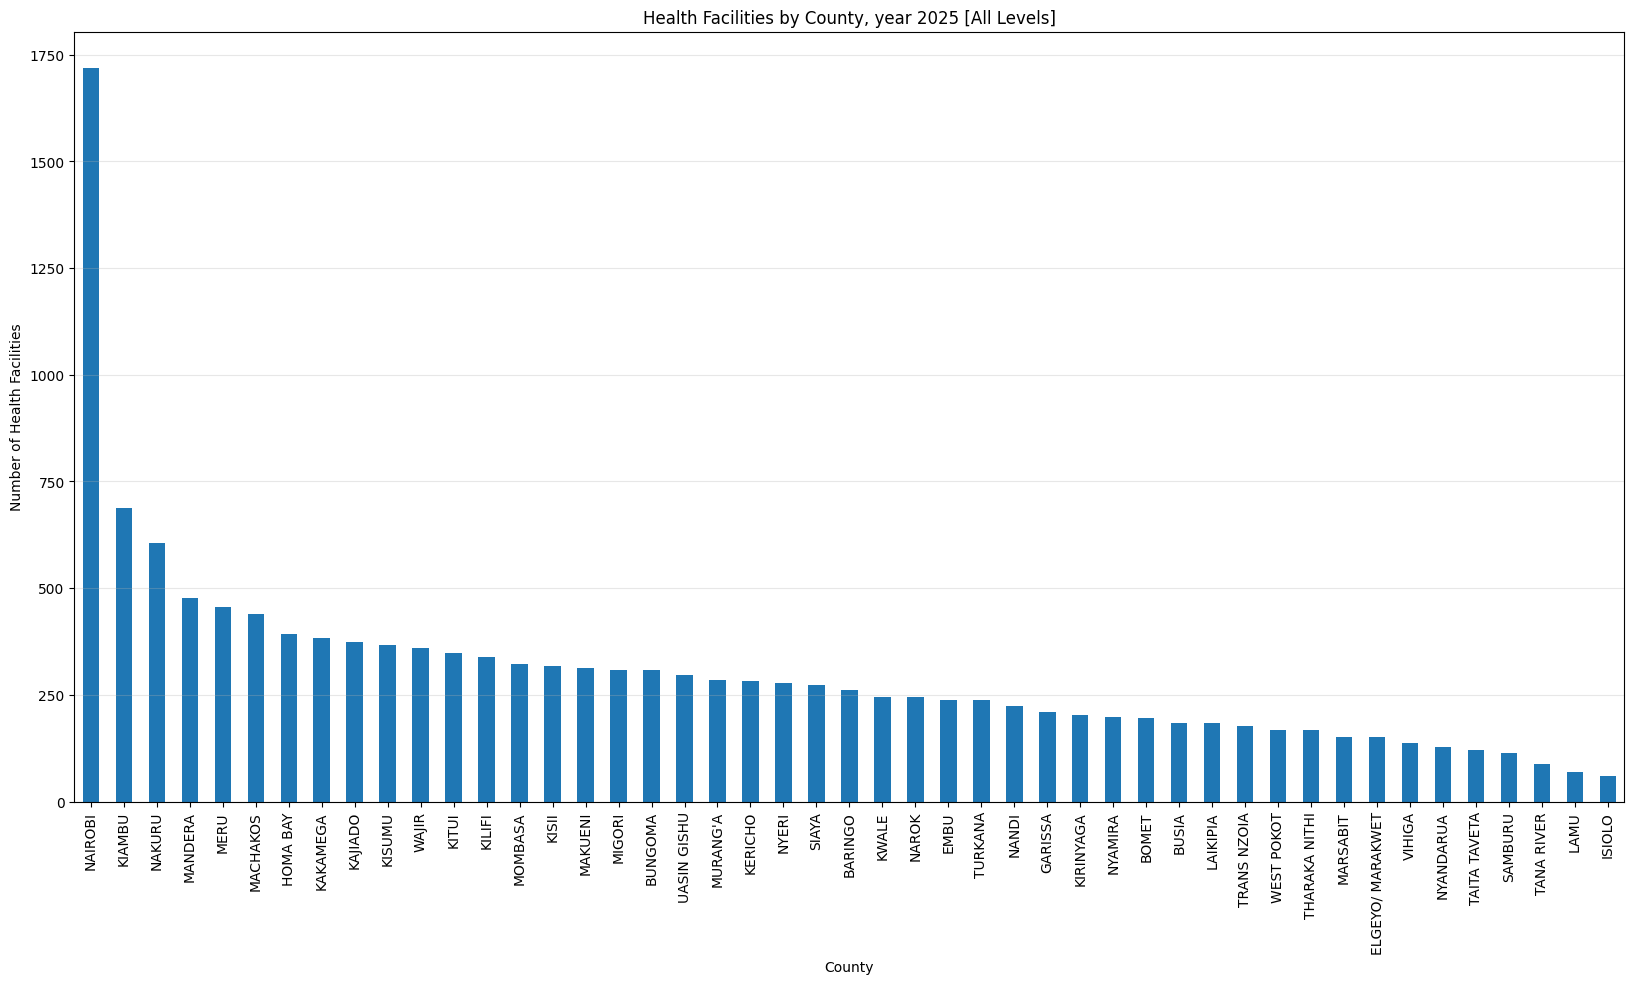
count 47.000000 mean 299.957447 std 247.828654 min 61.000000 25%
180.500000 50% 261.000000 75% 342.500000 max 1718.000000 dtype: float64

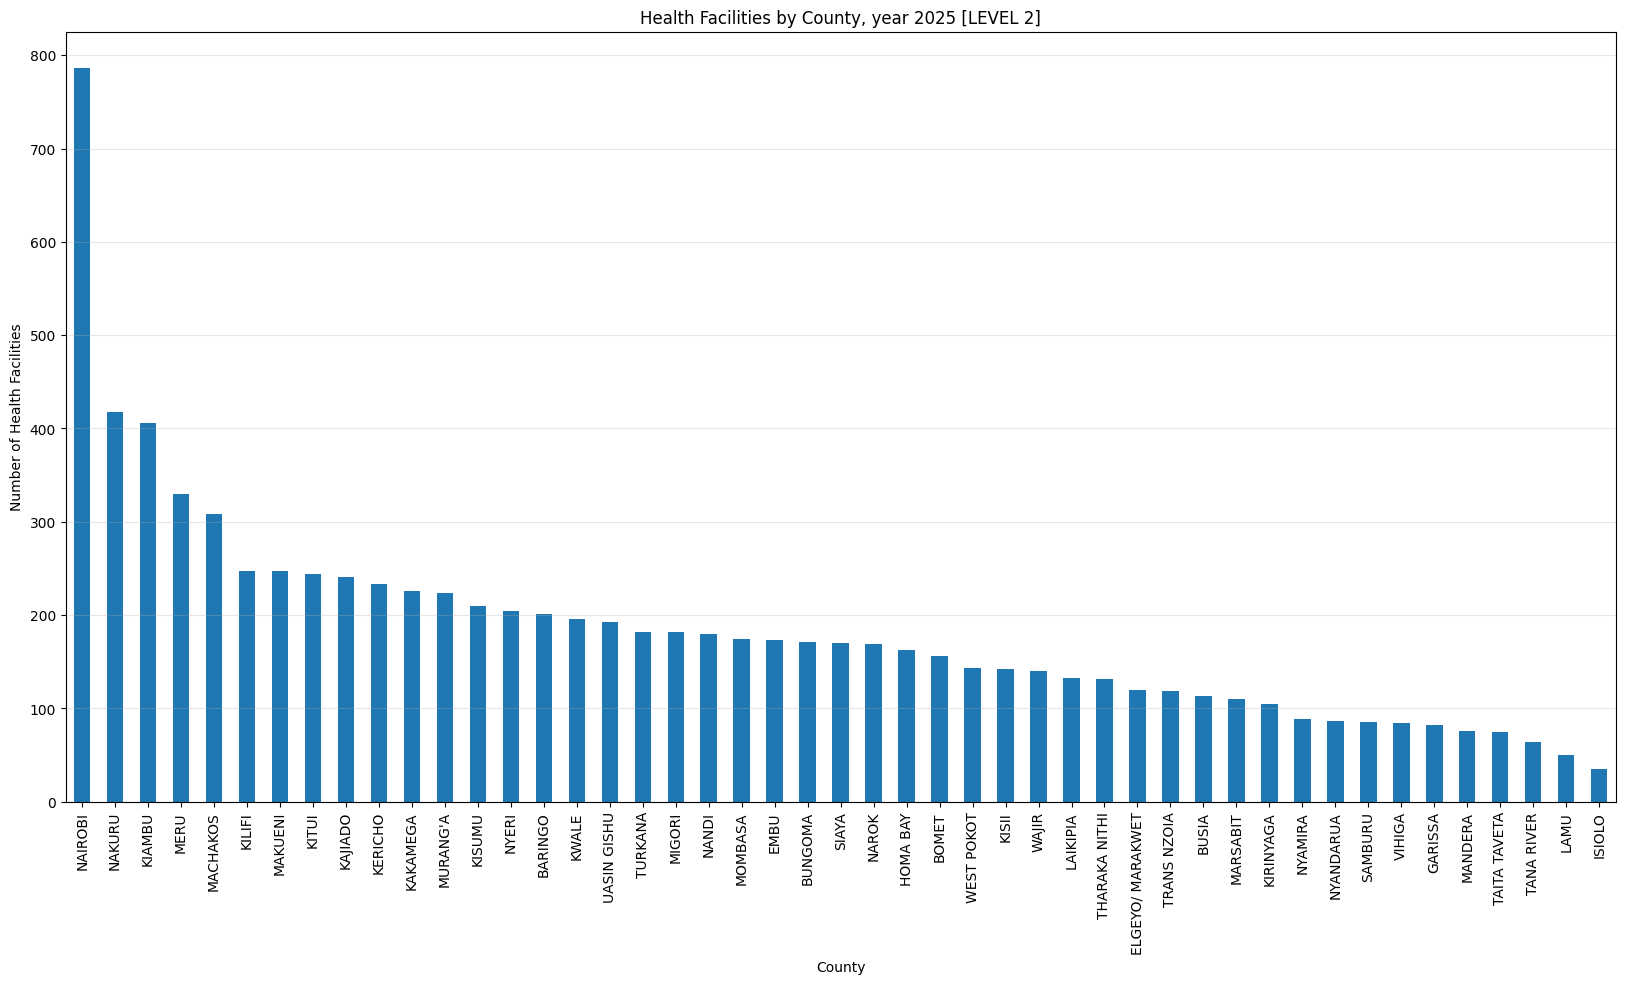

count     47.000000
mean     183.297872
std      122.494350
min       35.000000
25%      111.500000
50%      170.000000
75%      217.000000
max      786.000000
dtype: float64

In [43]:
health_facilities_county(
    'Health Facilities by County, year 2025 [LEVEL 2]',
    ['LEVEL 2'])

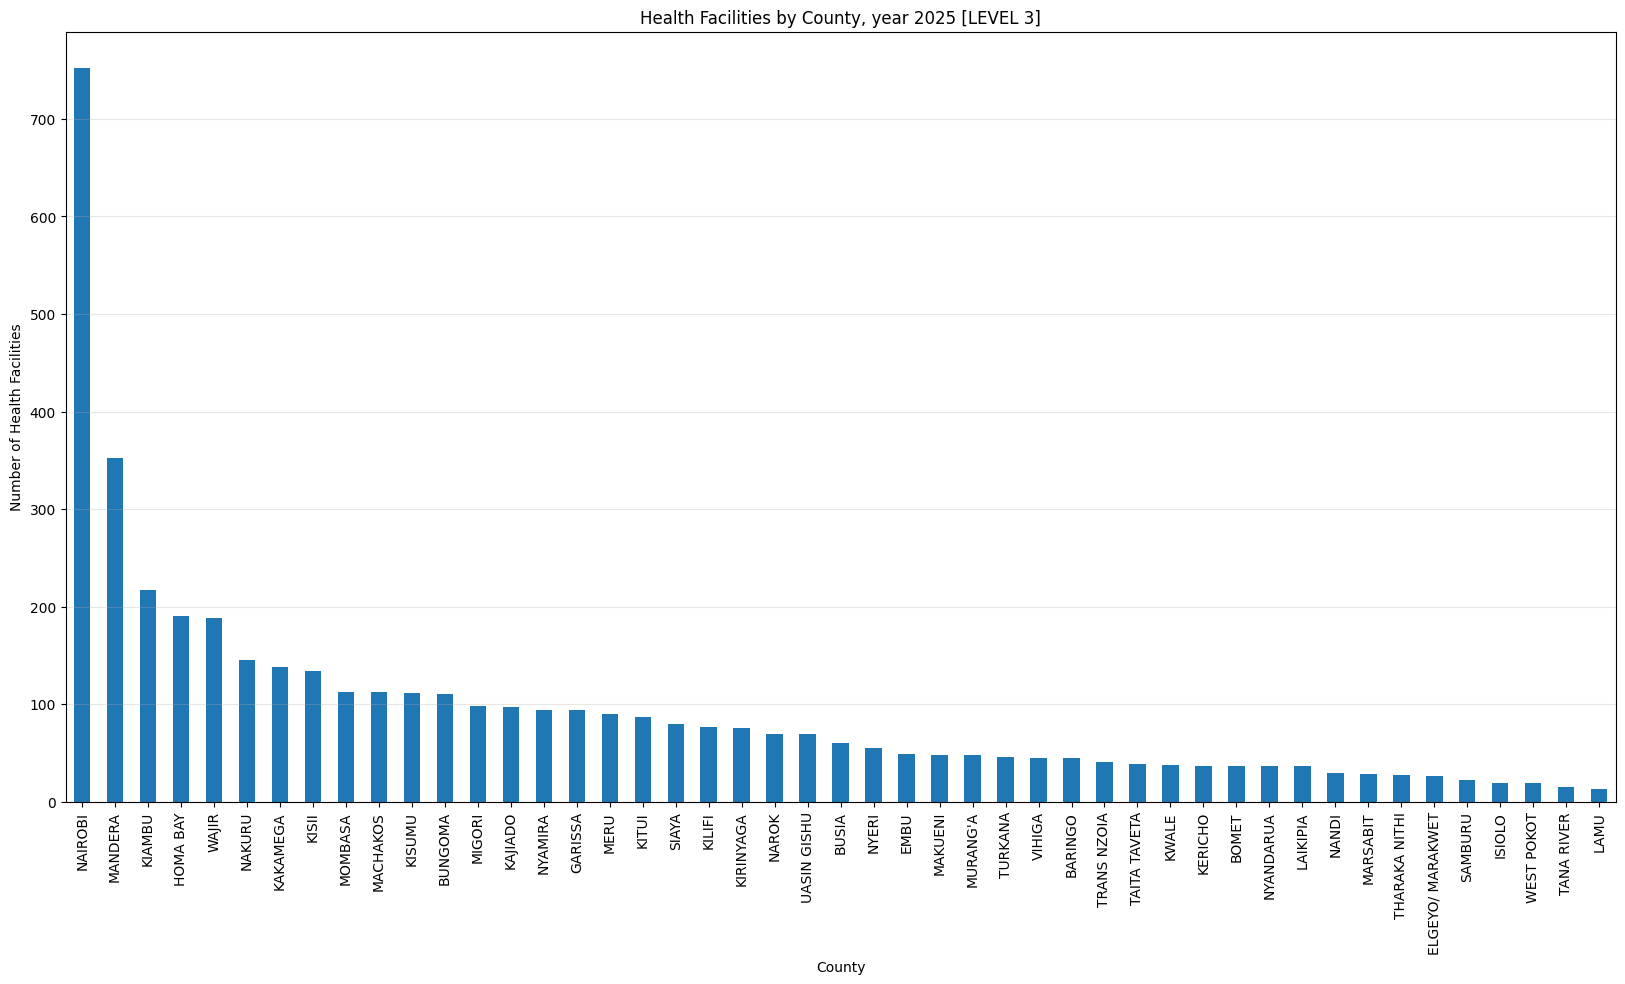

count     47.000000
mean      92.510638
std      116.786850
min       13.000000
25%       36.500000
50%       60.000000
75%      104.000000
max      752.000000
dtype: float64

In [44]:
health_facilities_county(
    'Health Facilities by County, year 2025 [LEVEL 3]',
    ['LEVEL 3A', 'LEVEL 3B'])

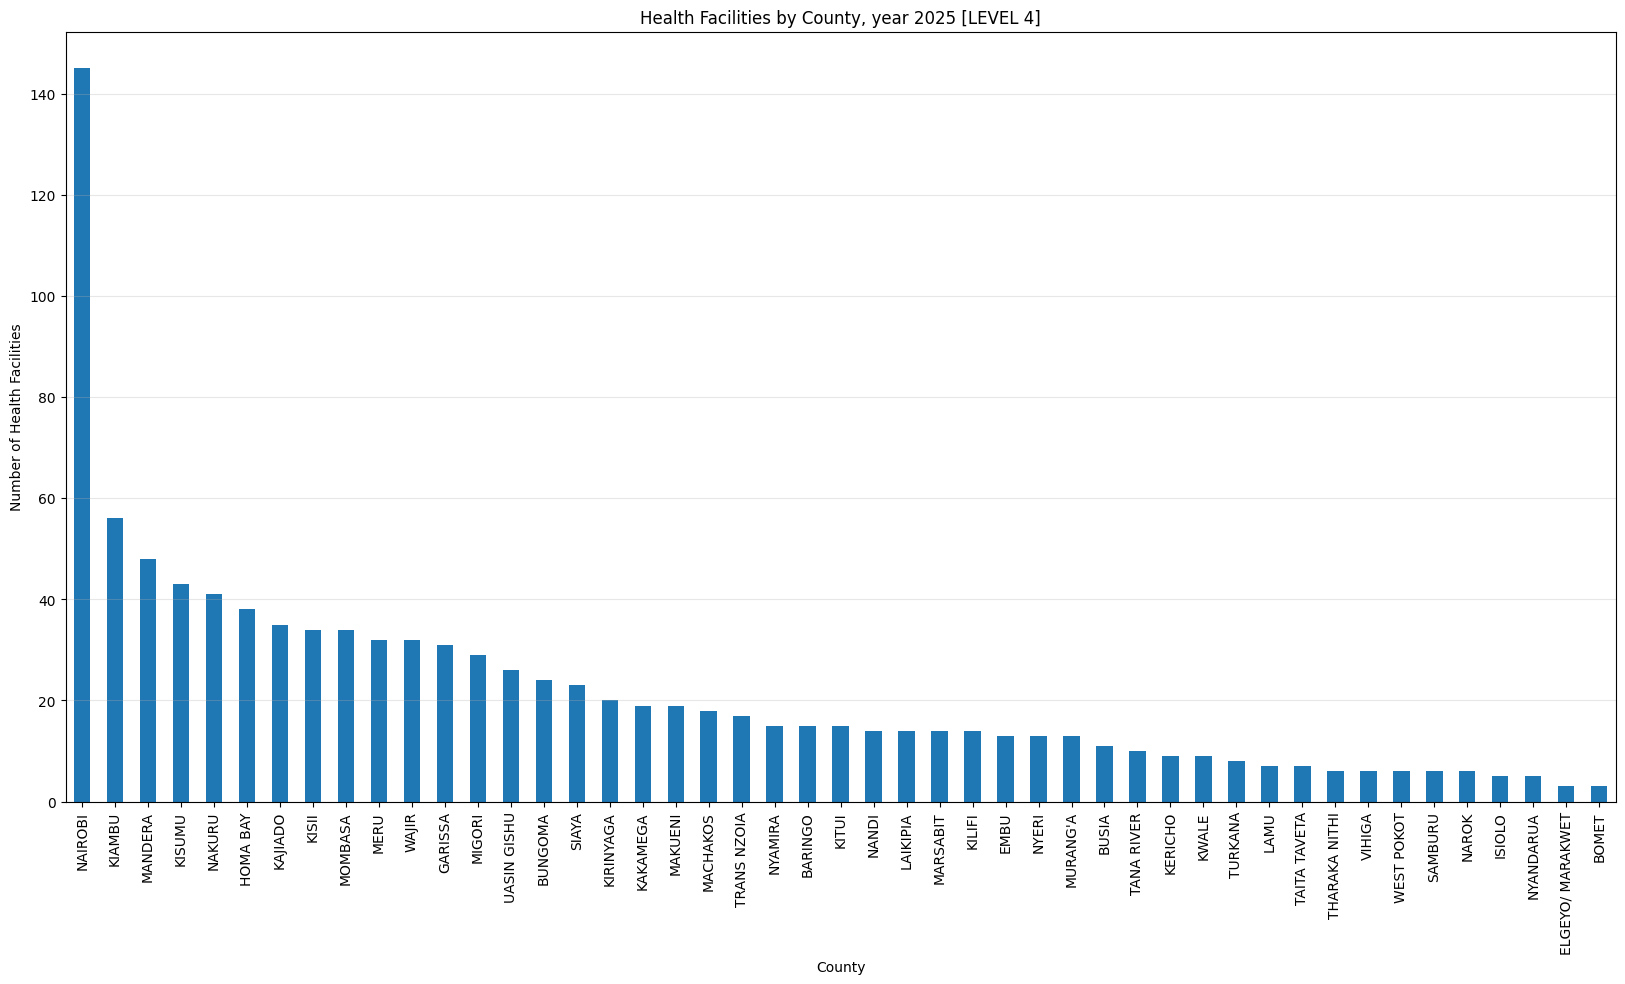

count     47.000000
mean      21.510638
std       22.531980
min        3.000000
25%        8.500000
50%       15.000000
75%       30.000000
max      145.000000
dtype: float64

In [45]:
health_facilities_county(
    'Health Facilities by County, year 2025 [LEVEL 4]',
    ['LEVEL 4', 'LEVEL 4B'])

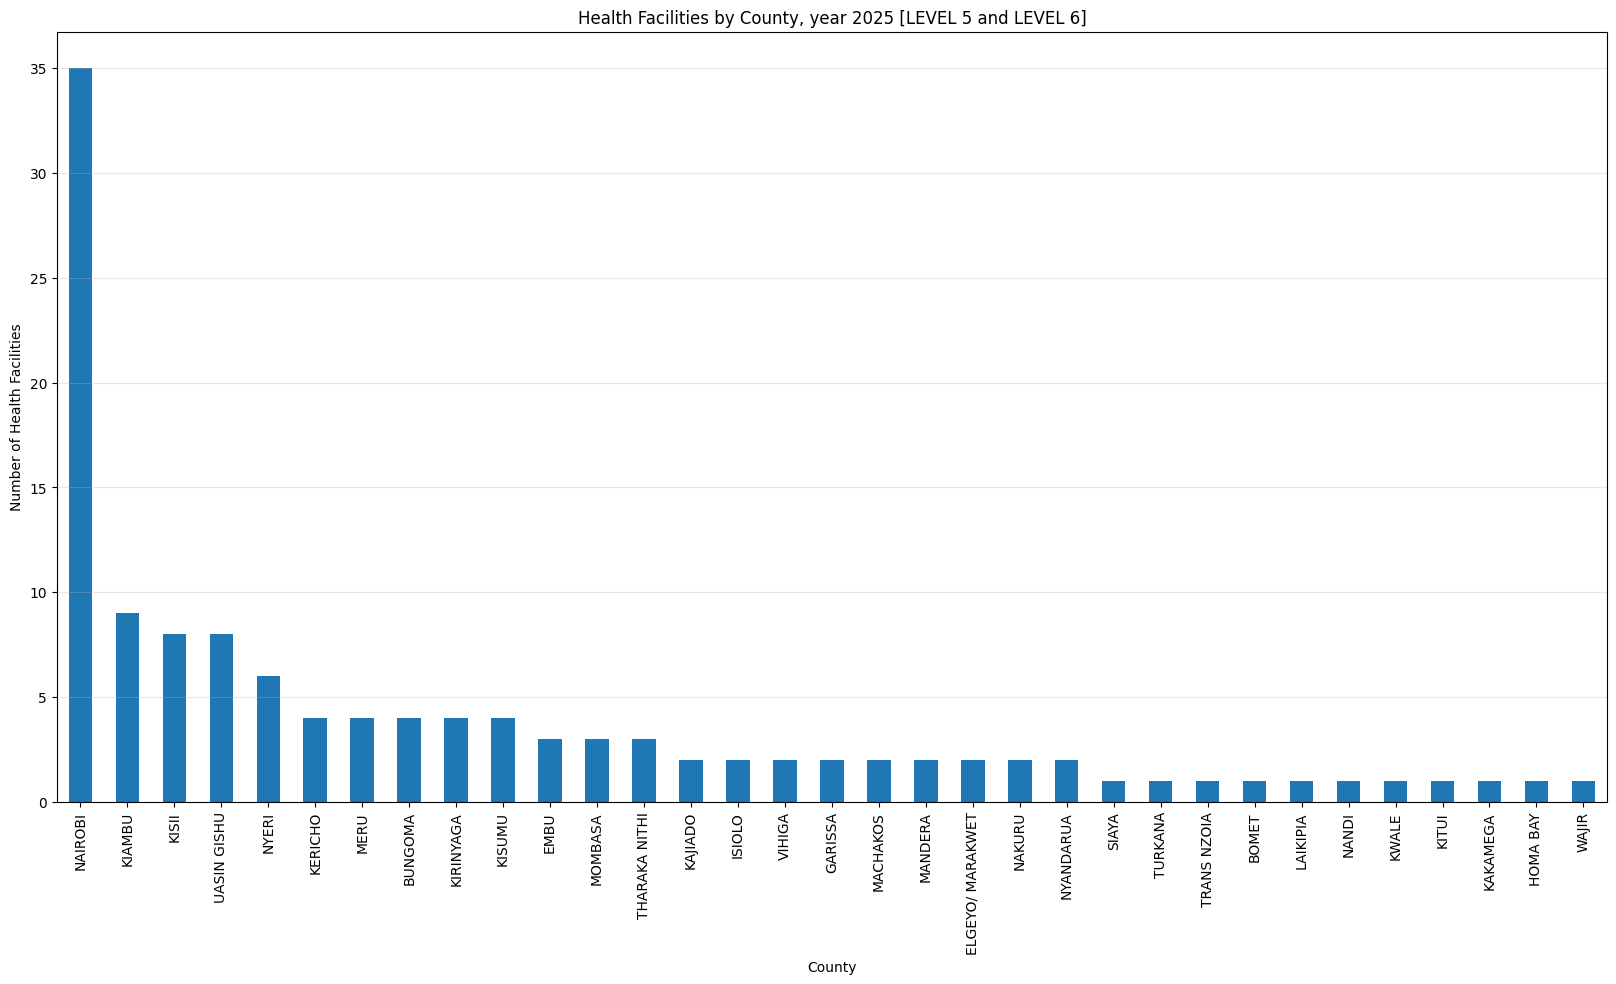

count    33.000000
mean      3.757576
std       6.015762
min       1.000000
25%       1.000000
50%       2.000000
75%       4.000000
max      35.000000
dtype: float64

In [46]:
health_facilities_county(
    'Health Facilities by County, year 2025 [LEVEL 5 and LEVEL 6]',
    ['LEVEL 5', 'LEVEL 6A', 'LEVEL 6B'])

Only three counties have more than 500 helath facilities (Nairobi,
Kiambu and Nakuru). Nairobi county leads with 1,718 facilities while
Isiolo county tails with 61 facilities.

### Hospital Density

If we gave each health facility a score depending on the level, and sum
the scores for each county, we can get a simplistic estimate of the
healthcare density in each county. The score is calculated as follows:

In [47]:
facility_level_values = { 
    j: i 
    for i, j 
    in enumerate(
        health_facilities_df['Level'].sort_values().unique().tolist(), start = 1)
}
facility_level_values

{'LEVEL 2': 1,
 'LEVEL 3A': 2,
 'LEVEL 3B': 3,
 'LEVEL 4': 4,
 'LEVEL 4B': 5,
 'LEVEL 5': 6,
 'LEVEL 6A': 7,
 'LEVEL 6B': 8}

In [48]:
density_data = [
    [
        county, 
        int(pd.to_numeric(facilities["Level"].apply(lambda x: facility_level_values[x])).sum()),
        int(facilities["Level"].count()),
    ] 
    for county, facilities 
    in health_facilities_df.groupby('County')
]
density_df = pd.DataFrame(density_data, columns=['County', 'Density', 'Count'])\
    .sort_values('Density', ascending=False)\
    .reset_index(drop=True)
density_df

Get the geometry of the counties in Kenya, [GADM (Global Administrative
Areas)](https://gadm.org/download_country.html).

In [49]:
gdf: gpd.geodataframe.GeoDataFrame = pygadm.Items(
    name="Kenya", content_level=1).rename(columns={"NAME_1": "County"})
gdf = gdf.drop(columns=list(set(gdf.columns) - set(["geometry", "County"])), 
              axis=1)
gdf.head(5)

Merge the densities and the geometries

In [50]:
def format_county_name(county_name: pd.Series) -> pd.Series:
    return county_name.str.strip().str.lower().str.replace(r'[^a-zA-Z0-9]+', '-', regex=True).str.title().unique()
density_df['County'] = format_county_name(density_df['County'])
gdf['County'] = format_county_name(gdf['County'])
merged_gdf = gdf.merge(density_df, on='County', how='left')
merged_gdf.head(5)

Plotting the simplistic densities gives us the following map.

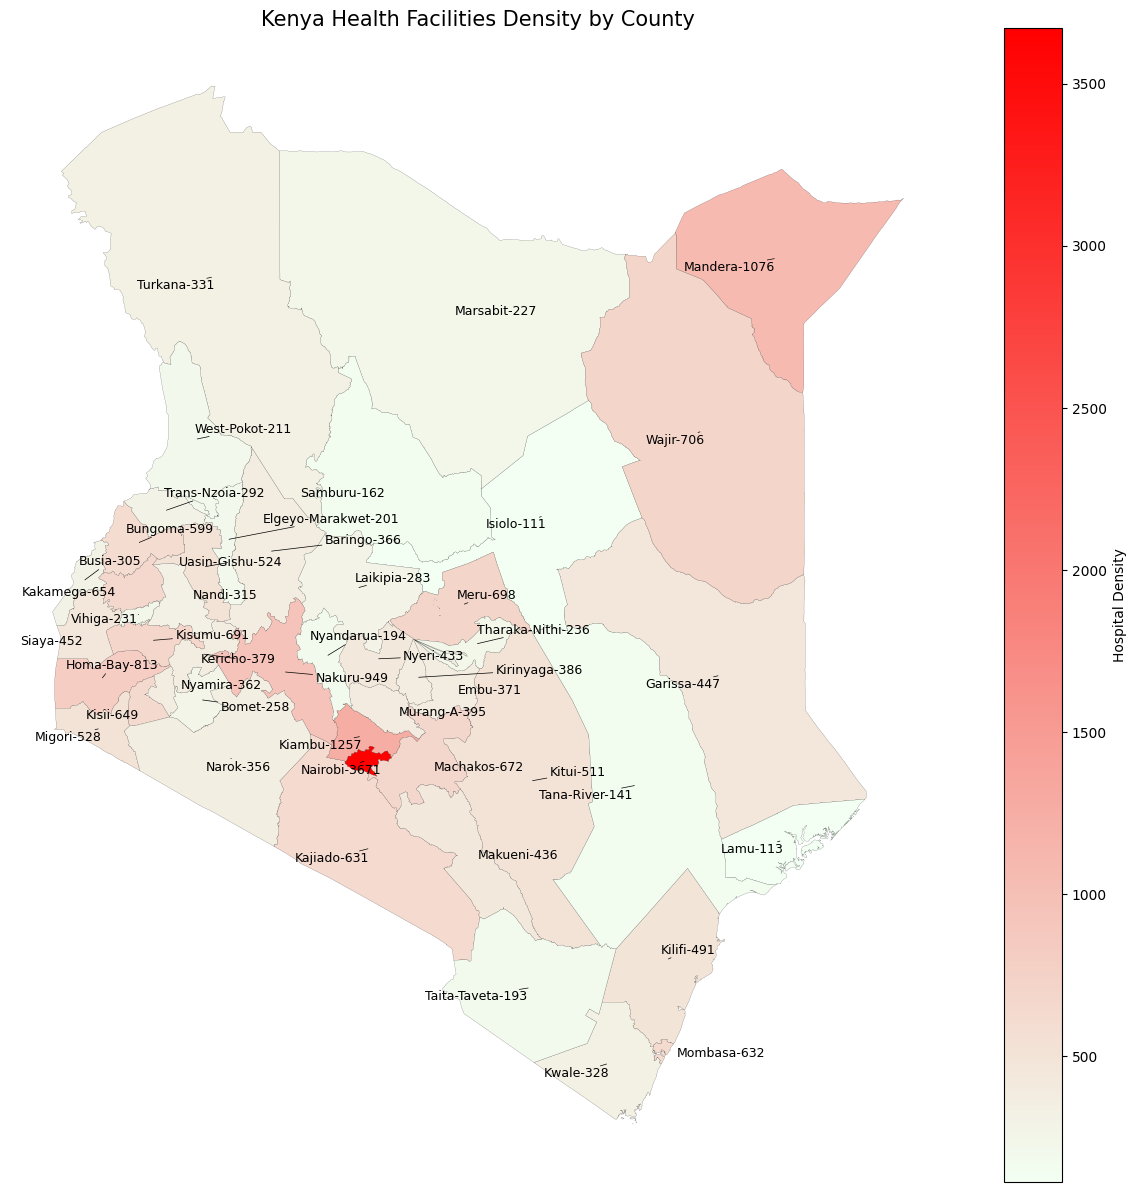

In [52]:
# Create figure and axis
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Create a custom colormap from green to red
cmap = colors.LinearSegmentedColormap.from_list('custom_cmap', ['#f2fff2', '#ff0000'])

# Plot with hospital count determining the color
merged_gdf.plot(
    ax=ax, 
    column='Density', 
    cmap=cmap, 
    legend=True,
    legend_kwds={'label': "Hospital Density", 'orientation': "vertical"},
    linewidth=0.1, edgecolor='black'
)

texts = [
    ax.text(
        row.geometry.centroid.x, 
        row.geometry.centroid.y, 
        f"{row['County']}-{row['Density']}",  # Just show the count
        fontsize=9,
        ha='center',
        va='center',
        color='black',
        # fontweight='bold',
        # bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3')
    )
    for idx, row 
    in merged_gdf.iterrows()]
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black', lw=0.5))

# Add title and remove axes
plt.title('Kenya Health Facilities Density by County', fontsize=15)
plt.axis('off')

# Show the map
plt.tight_layout()
plt.show()

------------------------------------------------------------------------

***Disclaimer:*** *For information only. Accuracy or completeness not
guaranteed. Illegal use prohibited. Not professional advice or
solicitation.* ***Read more:
[/terms-of-service](https://toknow.ai/terms-of-service)***